In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
# read in M92 data
file_path = 'NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt'
data = np.genfromtxt(file_path, skip_header=2)

F606W, F606Werr = data[:, 3], data[:, 4]
F814W, F8184err = data[:, 7], data[:, 8]

# get rid of anything with more than 0.2 mag errors
good_mask = (F606Werr < 0.2) & (F8184err < 0.2)
F606W, F606Werr, F814W, F8184err = F606W[good_mask], \
    F606Werr[good_mask], F814W[good_mask], F8184err[good_mask]

In [299]:
# directory with a bunch of isochrone files. 
MIST_dir = '/Users/kareem/Desktop/Proposals/imf/isochrones/MIST/MIST_v1.0_HST_ACSWF/'
PARSEC_dir = '/Users/kareem/Desktop/Proposals/imf/isochrones/parsec/grids/'

# for MIST, PARSEC outputs
col_606 = [12, 13]
col_814 = [17, 18]
col_phase = [20, 21]

def get_hess_diagram(F606W, F814W, x_range = [-0.2, 1.5], 
        y_range = [10, 28], bins = 100):
    x, y = F606W - F814W, F606W
    xbins = np.linspace(x_range[0], x_range[1], bins)
    ybins = np.linspace(y_range[0], y_range[1], bins)
    img = np.histogram2d(x, y, bins = [xbins, ybins])
    hess = img[0].T
    return xbins, ybins, hess

def get_isochrone_data(file_path):
    isochrone_data = np.genfromtxt(file_path)
    return isochrone_data

def get_log_ages(data):
    ages = data[:, 1]
    unique_ages = list(set(list(ages)))
    return sorted(unique_ages)

def get_isochrone(data, logage, code = 'MIST'):
    if code == 'MIST':
        ind = 0
        max_phase = 3
    elif code == 'PARSEC':
        ind = 1
        max_phase = 4
    mask = np.isclose(data[:, 1], logage)
    this_606 = data[:, col_606[ind]][mask]
    this_814 = data[:, col_814[ind]][mask]
    this_phase = data[:, col_phase[ind]][mask]
    x, y = this_606 - this_814, this_606
    phase_mask = this_phase < max_phase # get rid of hgb, etc. 
    return x[phase_mask], y[phase_mask]

# measure quality of fit by the total number of high-density bins the isochrone passes through
# computationally easier, though not rigorously justified. 
def interpolate_isochrone_to_pixel_space(iso_x, iso_y, 
    pixel_xbins, pixel_ybins):
    '''
    for fitting Hess diagram
    '''
    # from NED
    dist_mod = 14.9
    reddening = 0.04
    nbins = len(pixel_xbins)
    new_x = np.interp(iso_x + reddening, pixel_xbins, np.arange(nbins))
    new_y = np.interp(iso_y + dist_mod, pixel_ybins, np.arange(nbins))
    return new_x, new_y

def calculate_total_overlap(hess, iso_x, iso_y, code = 'MIST'):
    '''
    basically the likelihood function. 
    "You should always have a generative model when performing a fit," they
    said. 
    Haha nope. 
    '''
    summ = 0
    if code == 'MIST':
        alpha = 10
    elif code == 'PARSEC':
        alpha = 8
    for i, x_pixel in enumerate(iso_x):
        this_row, this_col = int(iso_y[i]), int(x_pixel)
        try:
            this_sum = hess[this_row, this_col]
            # weight points higher up more heavily. (Weighting function 
            # chosen pretty arbitrarily, without regard for IMF, etc).
            this_sum *= ((np.shape(hess)[0] - this_row)/np.shape(hess)[0])**alpha
            summ += this_sum
        except IndexError:
            pass # outside of image
    return summ

def fit_isochrone(hess, xbins, ybins, isochrones_dir, code = 'MIST'):
    import glob
    all_files = glob.glob(isochrones_dir+'*.cmd')
    if not len(all_files):
        all_files = glob.glob(isochrones_dir+'*.dat')
    best_sum = 0
    for i, f in enumerate(all_files):
        this_data = get_isochrone_data(f)
        unique_ages = get_log_ages(this_data)
        for logage in unique_ages:
            x, y = get_isochrone(this_data, logage, code = code)
            new_x, new_y = interpolate_isochrone_to_pixel_space(x, y, xbins, ybins)
            hess_sum = calculate_total_overlap(hess, new_x, new_y, code=code)
            if hess_sum > best_sum:
                best_sum = hess_sum
                best_file_num = i
                best_logage = logage
    return best_logage, all_files[best_file_num]

def fit_hess_diagram(isochrones_dir, F606W, F814W, x_range = [-0.2, 1.5], 
        y_range = [10, 28], bins = 50, code = 'MIST'):
    xbins, ybins, hess = get_hess_diagram(F606W, F814W, x_range = x_range, 
        y_range = y_range, bins = bins)
    best_logage, best_file = fit_isochrone(isochrones_dir = isochrones_dir, hess = hess, 
        xbins = xbins, ybins = ybins, code = code)
    return best_logage, best_file

def get_metallicity_from_filename(pathname, code = 'MIST'):
    if code == 'MIST':
        filename = pathname.split('/')[-1]
        second = filename.split('feh_')[-1]
        Z = second.split('_afe')[0]
        sign = Z[0]
        if sign == 'm':
            sgn = -1
        else:
            sgn = 1
        return sgn*float(Z[1:])
    elif code == 'PARSEC':
        filename = pathname.split('/')[-1]
        second = filename.split('Z_')[-1]
        first = second[:-4]
        Z = float(str('0.'+first))
        return np.log10(Z/0.0152) # their value
    
def plot_isochrone_fit(isochrones_dir, F606W, F814W, x_range = [-0.2, 1.5], 
        y_range = [10, 28], bins = 100, code = 'MIST'):
    best_logage, best_file = fit_hess_diagram(isochrones_dir = isochrones_dir, 
            F606W = F606W, F814W = F814W, x_range = x_range, y_range = y_range,
            bins = bins, code = code)
    xbins, ybins, hess = get_hess_diagram(F606W = F606W, F814W = F814W, 
            x_range = x_range, y_range = y_range, bins = bins)
    f = plt.figure()
    ax = f.add_subplot(111) 
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)
    im = ax.imshow(hess, cmap = 'gray', interpolation = 'nearest', 
        norm = LogNorm())
    ticks = np.linspace(0, bins, 5)
    ticks[-1] -= 1 
    ax.set_xlim(0, bins-1)
    ax.set_ylim(bins-1, 0)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(['%.2f' % j for j in np.interp(ticks, np.arange(bins), xbins)])
    ax.set_yticklabels(['%.2f' % j for j in np.interp(ticks, np.arange(bins), ybins)])
    ax.set_xlabel('F606W - F814W', fontsize = 20)
    ax.set_ylabel('F606W', fontsize = 20)
    ax.grid(False)
    cax = f.add_axes([0.85, 0.1, 0.04, 0.8])
    cbar = f.colorbar(im, cax=cax)
    cbar.set_label(r'$N_{\rm star}$', fontsize = 20)
    cbar.ax.tick_params(labelsize = 18)
    cbar.solids.set_rasterized(True)
    cbar.solids.set_edgecolor("face")
    this_data = get_isochrone_data(best_file)
    this_FeH = get_metallicity_from_filename(best_file, code=code)
    x, y = get_isochrone(this_data, best_logage, code=code)
    new_x, new_y = interpolate_isochrone_to_pixel_space(x, y, xbins, ybins)
    ax.plot(new_x, new_y, 'r')
    f.text(0.3, 0.84, '[Fe/H] = %.2f' % this_FeH, color = 'r')
    f.text(0.3, 0.8, 'age = %.2f Gyr' % ((10**float(best_logage))/1e9), color = 'r')
    ax.set_title(code, fontsize = 20)

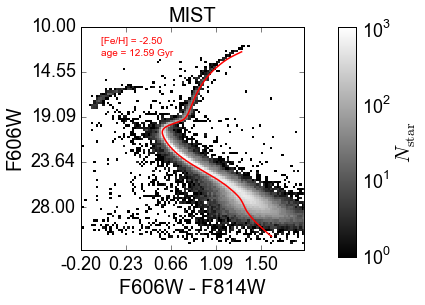

In [291]:
plot_isochrone_fit(isochrones_dir = MIST_dir, F606W = F606W, F814W = F814W, 
        x_range = [-0.2, 1.5], y_range = [10, 28], bins = 100, code='MIST')

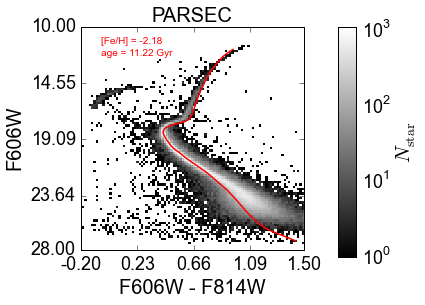

In [300]:
plot_isochrone_fit(isochrones_dir = PARSEC_dir, F606W = F606W, F814W = F814W, 
        x_range = [-0.2, 1.5], y_range = [10, 28], bins = 100, code='PARSEC')

These fits look OK by eye. I had to use some wonky hacks involving weighting bright stars more in the fit; otherwise my likelihood function would have been completely dominated by the many more dim stars than bright stars. So I don't trust the fits too much, but they're probably OK within a couple Gyr and a few tenths of a dex in metallicity. 

I can see by eye that the turnoff region appears to be fit somewhat better by the MIST models than the PARSEC models. To be honest, the main reason for this may be that my grid of MIST models is more finely sampled in age metallicity than my grid of PARSEC models. The PARSEC web interface forced me to download isochrones for different metallcities *one at a time* which I found an inexcuseable affront to my dignity. So I only downloaded ~10 different metallicities.

I think some of the difference between the two fits *is* driven by differences in the underlying stellar models, though: even though the PARSEC best-fit isochrone is 1.5 Gyr younger, its turn-off point is somewhat dimmer than the CMD. 


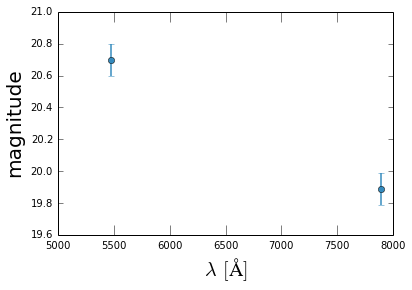

In [152]:
# problem 2
# here's the list of MIST isochrone values 'zmet' corresponds to
# https://github.com/cconroy20/fsps/blob/master/ISOCHRONES/MIST/zlegend.dat

# no dust

# To generate the "true" data which I'll try to recover by fitting, I'll use
# the best-fit values from fitting the isochrone with MIST models

# normalized such that one solar mass of stars is formed over the full SFH
import fsps

true_age = 12.59
true_FeH = -2.2
true_zred = 1.918797069301003e-06
sp_M92 = fsps.StellarPopulation(compute_vega_mags=True, sfh=0,
                                dust_type=0, sf_start=0, zcontinuous = 1, 
                               logzsol = true_FeH, redshift_colors = False, zred = 0)
VI_names = ['v', 'cousins_i']
true_VI_mags = sp_M92.get_mags(tage=true_age, bands=VI_names, redshift = true_zred)
true_VI_lambdas = [filt.lambda_eff for filt in [fsps.get_filter(name) for name in VI_names]]
f = plt.figure()
ax = f.add_subplot(111)
ax.errorbar(true_VI_lambdas, true_VI_mags, yerr = len(true_VI_mags)*[0.1], 
            fmt = 'o')
ax.set_xlabel(r'$\lambda\,[\AA]$', fontsize = 20)
ax.set_ylabel(r'magnitude', fontsize = 20)
#ax.set_ylim(7, 5)

In [158]:
def cosmology_one_over_E(z, Omega_M = 0.272, Omega_k = 0, Omega_Lambda = 0.728):
    '''
    convenience function for integration
    '''
    E_z = np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)
    return 1/E_z

def get_luminosity_distance_flat_universe(z, H0 = 70.2, Omega_M = 0.272):
    '''
    Does a numerical integral
    '''
    from scipy.integrate import quad
    c = 3e5 # km/s
    d_h = c/H0 # in Mpc
    d_h *= 1000 # in kpc
    Omega_Lambda = 1 - Omega_M    
    integral, error = quad(cosmology_one_over_E, 0, z, 
        args = (Omega_M, 0, Omega_Lambda,))
    d_M = d_h * integral
    d_L = (1 + z) * d_M
    return d_L


def get_redshift_of_luminosity_distance_flat_universe(d_L, H0 = 70.2, Omega_M = 0.272):
    '''
    returns the redshift at which the luminosity distance was a particular value.
    d_L in kpc.
    Tested against Ned Wright's cosmology calculator
    '''
    from scipy.optimize import brentq
    def func(z):
        return get_luminosity_distance_flat_universe(z, H0 = H0, Omega_M = Omega_M) - \
            d_L    
    bn = brentq(func, 0, 1000)
    return bn

def generate_new_mags(sp, filters = ['v', 'cousins_i'], dist = 10, logzsol = -2, age = 12.5):
    '''
    dist in kpc
    '''
    z = get_redshift_of_luminosity_distance_flat_universe(d_L = dist,
                    H0 = 70.2, Omega_M = 0.272)
    sp.params['logzsol'] = logzsol
    VI_mags = sp.get_mags(tage=age, bands=filters, redshift = z)
    return VI_mags

def lnlikelihood(sp, filters, theta, true_mags, true_mag_errs):
    '''
    assumes theta = (dist, logzsol, age)
    '''
    dist, logzsol, age = theta
    mags = generate_new_mags(sp, filters = filters, dist = dist, 
                             logzsol = logzsol, age = age)
    chi2 = sum((true_mags - mags)**2 / true_mag_errs **2)
    return -0.5*chi2

def theta_is_within_bounds(theta, theta_bounds):
    for i, param in enumerate(theta):
        this_min, this_max  = theta_bounds[i]
        
        if this_min is None:
            this_min = -np.inf
        if this_max is None:
            this_max = np.inf
        if not (this_min <= param < this_max):
            return False
    return True

def ln_flat_prior(theta, theta_bounds):
    if theta_is_within_bounds(theta, theta_bounds):
        return 0
    else: 
        return -np.inf

def lnpost(theta, theta_bounds, sp, filters, true_mags, true_mag_errs):
    lnprior = ln_flat_prior(theta = theta, theta_bounds = theta_bounds)
    if np.isfinite(lnprior):
        lnlike = lnlikelihood(sp = sp, filters = filters, theta = theta, 
                              true_mags = true_mags, true_mag_errs = true_mag_errs)
    else:
        lnlike = 0 
    return lnprior + lnlike

def get_good_p0_ball(p0, theta_bounds, nwalkers):
    num_good_p0 = 0
    ball_of_p0 = []
    while num_good_p0 < nwalkers:
        suggested_p0 = p0 + np.array([0.01*j*np.random.randn() for j in p0])
        suggested_p0_prob = ln_flat_prior(suggested_p0, theta_bounds = theta_bounds)
        if np.isfinite(suggested_p0_prob):
            ball_of_p0.append(suggested_p0)
            num_good_p0 += 1
    return ball_of_p0

def run_mcmc(p0, theta_bounds, sp, filters, true_mags, true_mag_errs, nwalkers = 200, 
                       n_steps = 200, burn = 50):
    import emcee
    ndim = len(p0)
    p0_ball = get_good_p0_ball(p0 = p0, theta_bounds = theta_bounds, nwalkers = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[theta_bounds, 
                                sp, filters, true_mags, true_mag_errs])
    pos, prob, state = sampler.run_mcmc(p0_ball, burn)
    sampler.reset()
    print('completed burn in ...')
    sampler.run_mcmc(pos, n_steps)
    return sampler

def fit_magnitudes(sp, mag_err = 0.1, nwalkers = 200,
                  n_steps = 200, burn = 10, filters = ['v', 'cousins_i'],
                  title = 'V and I only'):
    import corner
    true_mags = sp.get_mags(tage=true_age, bands=filters, redshift = true_zred)
    true_errs = np.array(len(true_mags) * [mag_err])
    p0 = [8.2, true_FeH, true_age]
    theta_bounds = [[1, 100], [-3, 1], [1, 25]]
    sampler = run_mcmc(p0 = p0, theta_bounds = theta_bounds, 
            sp = sp, filters = filters, true_mags = true_mags, true_mag_errs = true_errs,
            nwalkers = nwalkers, n_steps = n_steps, burn = burn)
    fig = corner.corner(sampler.flatchain, range = [0.99, 0.99, 0.99],
                 labels = ['dist (kpc)', '[Fe/H]', 'age (Gyr)'], label_kwargs={"fontsize": 20},
                 quantiles = [0.159, 0.5, 0.841], truths = p0)
    fig.text(0.4, 0.95, title, fontsize = 25)

completed burn in ...


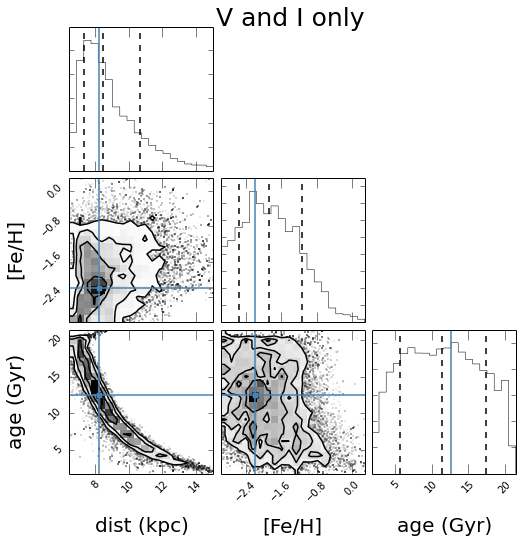

In [148]:
fit_magnitudes(sp_M92, mag_err = 0.1, n_steps=200, nwalkers = 200, 
               filters = ['v', 'cousins_i'], title = 'V and I only')

completed burn in ...


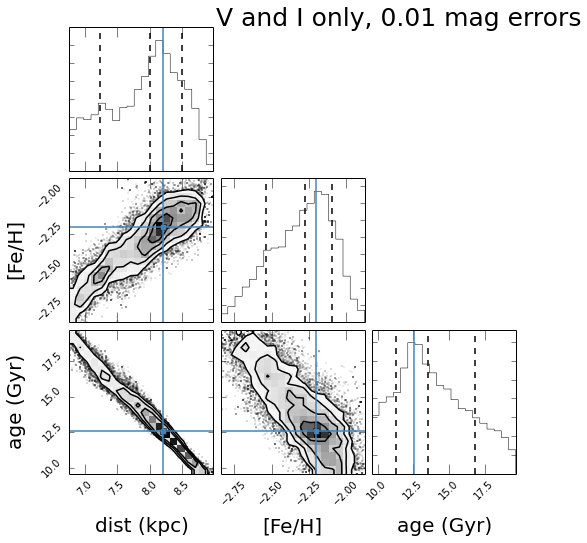

In [153]:
fit_magnitudes(sp_M92, mag_err = 0.01, n_steps=200, nwalkers = 200, 
               filters = ['v', 'cousins_i'], title = 'V and I only, 0.01 mag errors')

completed burn in ...


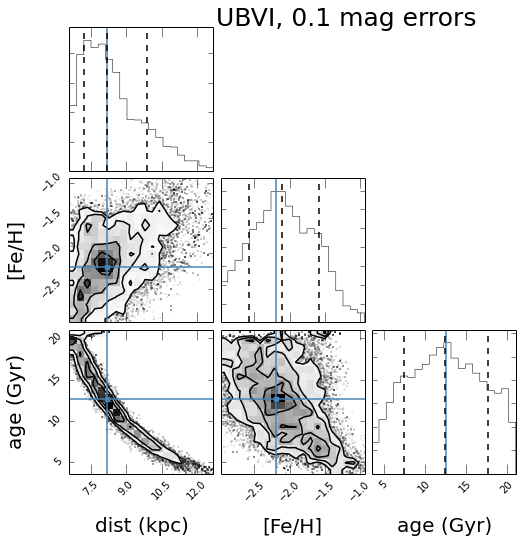

In [159]:
fit_magnitudes(sp_M92, mag_err = 0.1, n_steps=200, nwalkers = 200, 
               filters = ['u', 'b', 'v', 'cousins_i'], title = 'UBVI, 0.1 mag errors')

completed burn in ...


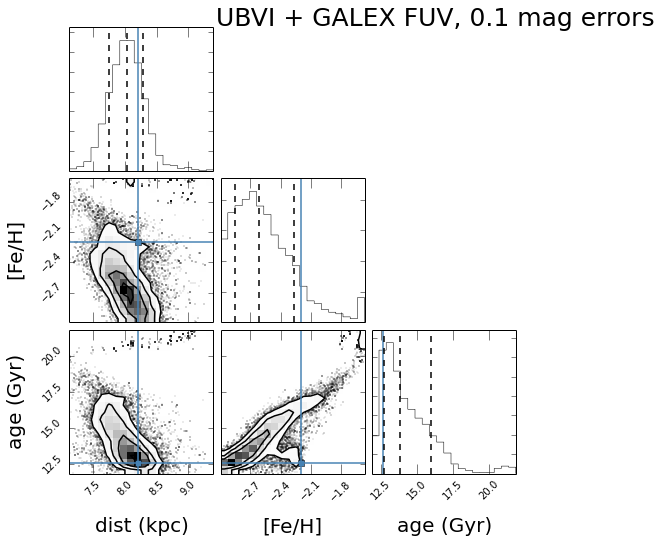

In [160]:
fit_magnitudes(sp_M92, mag_err = 0.1, n_steps=200, nwalkers = 200, 
               filters = ['galex_fuv', 'u', 'b', 'v', 'cousins_i'], 
               title = 'UBVI + GALEX FUV, 0.1 mag errors')

The fits improve significantly either by adding UV coverage or by getting smaller errors. Going from VI to UBVI doesn't make a big difference, though. 